# Brain Tumor Detection using Transfer Learning (Keras EfficientNetB0)

### Importar librerias necesarias

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix

### Transformar los datos

In [35]:
# Queremos etiquetar las imagenes para asi procesarlas mas facil posteriormente.

import os
import cv2

data_dir = "../data/Training" 

etiquetas = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

X = []
y = []

# Es mejor dividir las carpetas con un indice (0-pituitary_tumor, 1-meningioma_tumor, etc..).

for idx, etiqueta in enumerate(etiquetas):
    carpeta = os.path.join(data_dir, etiqueta)
    for img_name in os.listdir(carpeta):
        img_path = os.path.join(carpeta, img_name)
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) # IMREAD_COLOR son 3 canales RGB, mantengo asi compatibilidadd con arquitecturas predefinidas. 
        
        if img is not None:
            img = cv2.resize(img, (224, 224)) # Ese tamaño en especifico ya que EfficientNet
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            X.append(img)
            y.append(idx) 

X = np.array(X)
y = np.array(y)

X = X / 255.0 # Normaliza los valores de los píxeles, la red neuronal trabaja mejor con valores de 0.0 a 1.0.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes:
X_train: (2296, 224, 224, 3)
X_test: (574, 224, 224, 3)
y_train: (2296,)
y_test: (574,)


### Muestro imagenes para ver si he preparado bien los datos

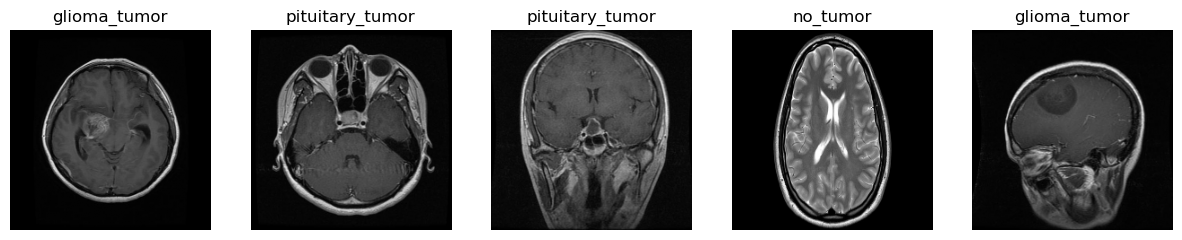

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title(etiquetas[y_train[i]])  # Sigue estando las label a valores 0-3 por el idx, pero uso etiqueta para saber el nombre.
    plt.axis('off')

plt.show()

### One Hot Encoding sobre las labels

In [37]:
# Normalmente las redes neuronales necesitan que las etiquetas estén en un formato ohe

from tensorflow.keras.utils import to_categorical

y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

print(y_train_ohe.shape)
print(y_test_ohe.shape)
print(y_train[:5])    
print(y_train_ohe[:5]) 

(2296, 4)
(574, 4)
[0 3 3 1 0]
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


### Para ahorrar tiempo y mejorar el rendimiento, voy a usar Transfer Learning

In [38]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False # Congelo los pesos, quiero mantener el modelo preentrenado tal cual lo he descargado

### Posterior al EffficientNet, debo añadir capas

In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
num_classes = y_train_ohe.shape[1]
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

### Una vez creado el modelo, es importante ver sus layers para entenderlo.

In [40]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Ahora, vamos a compilar el modelo.

In [42]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

### Una vez compilado, lo entrenamos usando callbacks para parar si no hay mejora.

In [43]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Detiene si no mejora val_loss
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6) # Reduce el learning rate, para saltar mas despacio
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True) # Guarda el mejor modelo segun val_loss

callbacks = [early_stopping, reduce_lr, checkpoint]

history = model.fit(X_train,y_train_ohe, validation_split=0.1, epochs =12, verbose=1, batch_size=32,callbacks=callbacks)

Epoch 1/12
65/65 ━━━━━━━━━━━━━━━━━━━━ 52s 596ms/step - accuracy: 0.2967 - loss: 1.3900 - val_accuracy: 0.2435 - val_loss: 1.3490 - learning_rate: 0.0010
Epoch 2/12
65/65 ━━━━━━━━━━━━━━━━━━━━ 35s 534ms/step - accuracy: 0.2543 - loss: 1.3783 - val_accuracy: 0.3087 - val_loss: 1.3638 - learning_rate: 0.0010
Epoch 3/12
65/65 ━━━━━━━━━━━━━━━━━━━━ 37s 572ms/step - accuracy: 0.2732 - loss: 1.3661 - val_accuracy: 0.3130 - val_loss: 1.3437 - learning_rate: 0.0010
Epoch 4/12
65/65 ━━━━━━━━━━━━━━━━━━━━ 35s 532ms/step - accuracy: 0.2668 - loss: 1.3704 - val_accuracy: 0.2435 - val_loss: 1.3578 - learning_rate: 0.0010
Epoch 5/12
65/65 ━━━━━━━━━━━━━━━━━━━━ 34s 524ms/step - accuracy: 0.2914 - loss: 1.3641 - val_accuracy: 0.3087 - val_loss: 1.3714 - learning_rate: 0.0010
Epoch 6/12
65/65 ━━━━━━━━━━━━━━━━━━━━ 34s 525ms/step - accuracy: 0.2780 - loss: 1.3760 - val_accuracy: 0.2435 - val_loss: 1.3527 - learning_rate: 0.0010
Epoch 7/12
65/65 ━━━━━━━━━━━━━━━━━━━━ 34s 524ms/step - accuracy: 0.2884 - loss: 1.

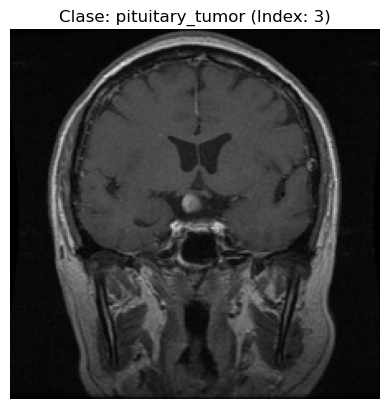

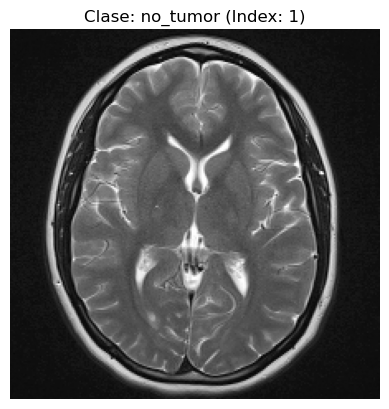

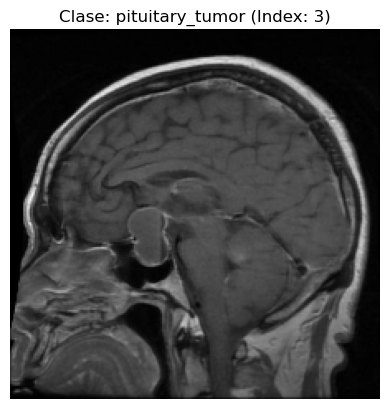

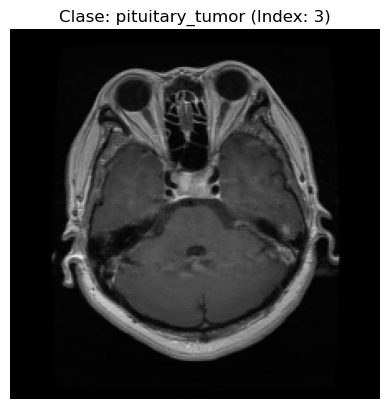

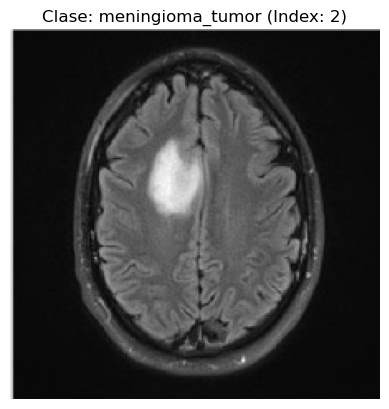

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def mostrar_imagenes_con_etiquetas(X, y_ohe, etiquetas, num_imagenes=5):
    
    indices = np.random.choice(len(X), num_imagenes, replace=False)

    for i in indices:
        img = X[i]
        label_idx = np.argmax(y_ohe[i])
        label_name = etiquetas[label_idx]

        plt.imshow(img)
        plt.title(f"Clase: {label_name} (Index: {label_idx})")
        plt.axis('off')
        plt.show()

mostrar_imagenes_con_etiquetas(X_train, y_train_ohe, etiquetas, num_imagenes=5)